In [1]:
from keras.layers import Input, Reshape, Flatten
from keras.models import Model, load_model
from keras.layers import Input, Conv2D, Activation, Dense
from keras.utils.vis_utils import plot_model
from keras.optimizers import Adam
import numpy as np
import keras
import tensorflow as tf
from keras.models import Sequential

import os
# Esto es solo necesario en el caso de tener varías GPUs en el equipo (comentar en Colab)
os.environ["CUDA_VISIBLE_DEVICES"]="1" 

import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt

import random
import matplotlib as mpl

Using TensorFlow backend.


#### En este Notebook se implementará la red neuronal capaz de generar pinceladas a partir de unos datos generados de forma aleatoria y que definen cada uno de los strokes.

## Definición de la capa subpixel

#### En la siguiente celda se define la capa subpixel necesaria para definir la red neuronal. Las capas subpixel permiten mejorar la resolución podemos obtener más info de estas capas aquí: https://arxiv.org/abs/1609.05158 . En pytorch existe una definición directa de estas capas, sin embargo, en keras no, por ello, es necesario implementarlas:

In [2]:
from keras.engine import Layer
import tensorflow as tf

from keras.utils.generic_utils import get_custom_objects

class SubpixelConv2D(Layer):
    """ Subpixel Conv2D Layer
    upsampling a layer from (h, w, c) to (h*r, w*r, c/(r*r)),
    where r is the scaling factor, default to 4
    # Arguments
    upsampling_factor: the scaling factor
    # Input shape
        Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a model.
    # Output shape
        the second and the third dimension increased by a factor of
        `upsampling_factor`; the last layer decreased by a factor of
        `upsampling_factor^2`.
    # References
        Real-Time Single Image and Video Super-Resolution Using an Efficient
        Sub-Pixel Convolutional Neural Network Shi et Al. https://arxiv.org/abs/1609.05158
    """

    def __init__(self, upsampling_factor=4, **kwargs):
        super(SubpixelConv2D, self).__init__(**kwargs)
        self.upsampling_factor = upsampling_factor

    def build(self, input_shape):
        last_dim = input_shape[-1]
        factor = self.upsampling_factor * self.upsampling_factor
        if last_dim % (factor) != 0:
            raise ValueError('Channel ' + str(last_dim) + ' should be of '
                             'integer times of upsampling_factor^2: ' +
                             str(factor) + '.')

    def call(self, inputs, **kwargs):
        return tf.nn.depth_to_space( inputs, self.upsampling_factor )
        #return Lambda(lambda x:tf.nn.depth_to_space( inputs, self.upsampling_factor ))

    def get_config(self):
        config = { 'upsampling_factor': self.upsampling_factor, }
        base_config = super(SubpixelConv2D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        factor = self.upsampling_factor * self.upsampling_factor
        input_shape_1 = None
        if input_shape[1] is not None:
            input_shape_1 = input_shape[1] * self.upsampling_factor
        input_shape_2 = None
        if input_shape[2] is not None:
            input_shape_2 = input_shape[2] * self.upsampling_factor
        dims = [ input_shape[0],
                 input_shape_1,
                 input_shape_2,
                 int(input_shape[3]/factor)
               ]
        return tuple( dims )

get_custom_objects().update({'SubpixelConv2D': SubpixelConv2D})



## Definición de la red

#### A continuación se define el dataGenerator que permite obtener los datos que generan las pinceladas de forma aleatoria y la definición de la red neuronal.

In [3]:
def generator():
    
    while True:
        
        train_batch = []
        ground_truth = []
        #CAMBIO EL BATCH SIZE POR EL ERROR: OOM when allocating tensor with shape
        #OM when allocating tensor with shape[12992,8,64,64] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
        for i in range(64):
            f = np.random.uniform(0, 1, 11)
            train_batch.append(f)
            ground_truth.append(draw(f)/255)
        
        batch_x = np.array( train_batch, dtype='float32' )
        batch_y = np.array( ground_truth, dtype='float32' )

        yield ( batch_x, batch_y )

In [4]:
ip = Input(shape=(11,))
x = Dense(512, activation='relu', name='fc1')(ip)
x = Dense(1024, activation='relu', name='fc2')(x)
x = Dense(2048, activation='relu', name='fc3')(x)
x = Dense(4096, activation='relu', name='fc4')(x)
x = Reshape((-1,16,16))(x)
x = Conv2D(32, (3,3), activation='relu',strides=(1, 1), padding = "same")(x)
x = SubpixelConv2D(upsampling_factor=2)(Conv2D(32, (3,3), strides=(1, 1), padding = "same")(x))
x = Conv2D(16, (3,3), activation='relu', strides=(1, 1), padding = "same")(x)
x = SubpixelConv2D(upsampling_factor=2)(Conv2D(16, (3,3), strides=(1, 1), padding = "same")(x))
x = Conv2D(8, (3,3), activation='relu', strides=(1, 1), padding = "same")(x)
x = Conv2D(12, (3,3), strides=(1, 1), padding = "same")(x)
x = SubpixelConv2D(upsampling_factor=2)(x)

x = Activation('sigmoid')(x)


model = Model(ip, x)

model.compile(loss = "mean_squared_error", optimizer=Adam(), metrics=['mae'])
model.summary()
#model.save('model.h5')
print("*"*80)



Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 11)                0         
_________________________________________________________________
fc1 (Dense)                  (None, 512)               6144      
_________________________________________________________________
fc2 (Dense)                  (None, 1024)              525312    
_________________________________________________________________
fc3 (Dense)                  (None, 2048)              2099200   
_________________________________________________________________
fc4 (Dense)                  (None, 4096)              8392704   
_________________________________________________________________
reshape_1 (Reshape)          (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        4640

## Generamos las pinceladas

#### Definimos las funciones que nos permiten generar las pinceldas según los datos generados anteriormente de forma aleatoria. Estos resultados sería el ground_truth.

In [5]:
import cv2
import numpy as np

def normal(x, width):
    return (int)(x * (width - 1) + 0.5)

def random_color():
    r = random.randint(0,255)
    g = random.randint(0,255)
    b = random.randint(0,255)
    rgb = [r,g,b]
    return rgb

def draw(f, width=128):
    x0, y0, x1, y1, x2, y2, z0, z2, r, g, b = f
    
    #color = random_color()
    r, g, b = r*255, g*255, b*255

    x1 = x0 + (x2 - x0) * x1
    y1 = y0 + (y2 - y0) * y1
    x0 = normal(x0, width * 2)
    x1 = normal(x1, width * 2)
    x2 = normal(x2, width * 2)
    y0 = normal(y0, width * 2)
    y1 = normal(y1, width * 2)
    y2 = normal(y2, width * 2)
    z0 = (int)(1 + z0 * width // 2)
    z2 = (int)(1 + z2 * width // 2)
    canvas = 255 * np.ones([width * 2, width * 2, 3], dtype=np.uint8)
    tmp = 1. / 100
    for i in range(100):
        t = i * tmp
        x = (int)((1-t) * (1-t) * x0 + 2 * t * (1-t) * x1 + t * t * x2)
        y = (int)((1-t) * (1-t) * y0 + 2 * t * (1-t) * y1 + t * t * y2)
        z = (int)((1-t) * z0 + t * z2)
        #w = (1-t) * w0 + t * w2
        cv2.circle(canvas, (y, x), z , [r,g,b] , -1)
    
   # plt.imshow(canvas)
        
    return  cv2.resize(canvas, dsize=(width, width))
    #plt.imshow(canvas)



## Entrenamiento del modelo

#### El siguiente paso sería comenzar a entrenar nuestra red para ver si es capaz de generar pinceladas. 

In [6]:
#train_gen = generator()

In [7]:
history = model.fit_generator(generator(),epochs=20, steps_per_epoch=2000 , verbose=1)

Epoch 1/20
2000/2000 [==============================] - 74s 37ms/step - loss: 0.0614 - mae: 0.0945
Epoch 2/20
2000/2000 [==============================] - 74s 37ms/step - loss: 0.0542 - mae: 0.0904
Epoch 3/20
2000/2000 [==============================] - 73s 37ms/step - loss: 0.0152 - mae: 0.0486
Epoch 4/20
2000/2000 [==============================] - 74s 37ms/step - loss: 0.0099 - mae: 0.0353
Epoch 5/20
2000/2000 [==============================] - 73s 37ms/step - loss: 0.0052 - mae: 0.0233
Epoch 6/20
2000/2000 [==============================] - 74s 37ms/step - loss: 0.0037 - mae: 0.0176
Epoch 7/20
2000/2000 [==============================] - 73s 37ms/step - loss: 0.0030 - mae: 0.0139
Epoch 8/20
2000/2000 [==============================] - 73s 37ms/step - loss: 0.0027 - mae: 0.0126
Epoch 9/20
2000/2000 [==============================] - 73s 37ms/step - loss: 0.0025 - mae: 0.0119
Epoch 10/20
2000/2000 [==============================] - 73s 37ms/step - loss: 0.0023 - mae: 0.0112
Epoch 11/

In [8]:
model.save_weights('my_model_weights_patricia.h5')

In [9]:
f = np.random.uniform(0, 1, 11)
img = draw(f, width=128)

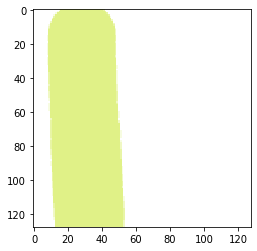

In [10]:
plt.imshow(img)
plt.show()

In [11]:
#nm = load_model( 'model_patricia.h5' )
#print("model loaded successfully")
#model.load_weights('my_model_weights.h5')
#print("weights loaded successfully")

In [12]:
def generator_predict():
    
    while True:
        
        train_batch = []
        train_batch.append(f)

        batch_x = np.array( train_batch, dtype='float32' )

        yield batch_x

y_pred_prob = model.predict_generator(generator_predict(), steps=1)

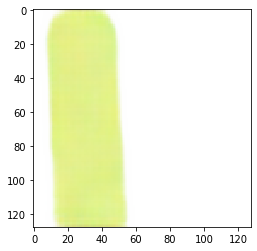

In [13]:
plt.imshow(y_pred_prob[0])
plt.show()

In [14]:
y_pred_prob.shape

(1, 128, 128, 3)

In [15]:
f

array([0.12199186, 0.22415005, 0.52791052, 0.26902345, 0.97890491,
       0.26368531, 0.62381985, 0.64841082, 0.8795355 , 0.9444203 ,
       0.52843825])

In [16]:
y_pred_prob[0].min()

0.4794288

In [17]:
np.unique(y_pred_prob[0].reshape((128*128, 3)), axis=0)

array([[0.8128112 , 0.8879395 , 0.48874837],
       [0.822027  , 0.88969845, 0.49846655],
       [0.8240713 , 0.89215684, 0.4850119 ],
       ...,
       [0.9999999 , 1.        , 1.        ],
       [1.        , 1.        , 0.9999999 ],
       [1.        , 1.        , 1.        ]], dtype=float32)

In [18]:
np.mean((y_pred_prob[0] - img / 255)**2)

0.0004501289764614681

In [19]:
np.unique(img.reshape((128*128, 3)), axis=0) / 255

array([[0.87843137, 0.94509804, 0.52941176],
       [0.90980392, 0.96078431, 0.64705882],
       [0.94117647, 0.97254902, 0.76470588],
       [0.96862745, 0.98823529, 0.88235294],
       [1.        , 1.        , 1.        ]])

In [20]:
model.evaluate_generator(generator(), steps=100)

[0.001713960082270205, 0.008487853221595287]

## Métricas de evaluación.

#### Métricas de evaluación para estudiar el comportamiento del modelo durante el entrenamiento.

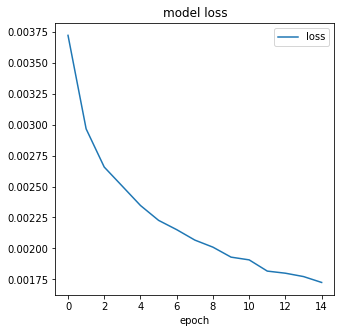

In [31]:
mpl.rcParams['figure.figsize'] = (5,5)
plt.plot(history.history['loss'][start_plot:], label = 'loss')
plt.title('model loss')
plt.xlabel('epoch')
plt.legend(['loss'], loc ='upper right')
plt.show()

In [22]:
all_mae_entrenamientos = []
mae_entrenamiento = history.history['mae']
all_mae_entrenamientos.append(mae_entrenamiento)

In [23]:
average_mae_entrenamiento = [
    np.mean([x[i] for x in all_mae_entrenamientos]) for i in range(20)]

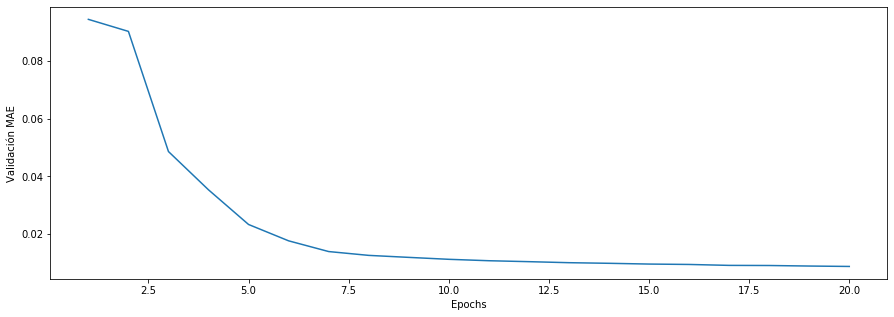

In [24]:
plt.plot(range(1, len(average_mae_entrenamiento) + 1), average_mae_entrenamiento)
plt.xlabel('Epochs')
plt.ylabel('Validación MAE')
plt.show()